In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

import lime
import lime.lime_tabular
import shap

from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
import plotly.express as px
init_notebook_mode(connected=True)
import plotly.graph_objs as go

In [2]:
df = pd.read_csv("DATA/KDDTrain+.txt")

columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot'
,'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations'
,'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate'
,'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count'
,'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate'
,'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','attack','level'])

df.columns = columns
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125972 non-null  int64  
 1   protocol_type                125972 non-null  object 
 2   service                      125972 non-null  object 
 3   flag                         125972 non-null  object 
 4   src_bytes                    125972 non-null  int64  
 5   dst_bytes                    125972 non-null  int64  
 6   land                         125972 non-null  int64  
 7   wrong_fragment               125972 non-null  int64  
 8   urgent                       125972 non-null  int64  
 9   hot                          125972 non-null  int64  
 10  num_failed_logins            125972 non-null  int64  
 11  logged_in                    125972 non-null  int64  
 12  num_compromised              125972 non-null  int64  
 13 

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,125972.0,287.146929,2.604526e+03,0.0,0.00,0.00,0.00,4.290800e+04
src_bytes,125972.0,45567.100824,5.870354e+06,0.0,0.00,44.00,276.00,1.379964e+09
dst_bytes,125972.0,19779.271433,4.021285e+06,0.0,0.00,0.00,516.00,1.309937e+09
land,125972.0,0.000198,1.408613e-02,0.0,0.00,0.00,0.00,1.000000e+00
wrong_fragment,125972.0,0.022688,2.535310e-01,0.0,0.00,0.00,0.00,3.000000e+00
urgent,125972.0,0.000111,1.436608e-02,0.0,0.00,0.00,0.00,3.000000e+00
hot,125972.0,0.204411,2.149977e+00,0.0,0.00,0.00,0.00,7.700000e+01
num_failed_logins,125972.0,0.001222,4.523932e-02,0.0,0.00,0.00,0.00,5.000000e+00
logged_in,125972.0,0.395739,4.890107e-01,0.0,0.00,0.00,1.00,1.000000e+00
num_compromised,125972.0,0.279253,2.394214e+01,0.0,0.00,0.00,0.00,7.479000e+03


In [5]:
df.drop('level', axis=1)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
1,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
2,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
3,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
4,0,tcp,private,REJ,0,0,0,0,0,0,...,19,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,neptune
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125967,0,tcp,private,S0,0,0,0,0,0,0,...,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune
125968,8,udp,private,SF,105,145,0,0,0,0,...,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal
125969,0,tcp,smtp,SF,2231,384,0,0,0,0,...,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal
125970,0,tcp,klogin,S0,0,0,0,0,0,0,...,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune


In [6]:
df['attack'].unique()

array(['normal', 'neptune', 'warezclient', 'ipsweep', 'portsweep',
       'teardrop', 'nmap', 'satan', 'smurf', 'pod', 'back',
       'guess_passwd', 'ftp_write', 'multihop', 'rootkit',
       'buffer_overflow', 'imap', 'warezmaster', 'phf', 'land',
       'loadmodule', 'spy', 'perl'], dtype=object)

In [7]:
# changing attack labels to their respective attack class
def change_label(df):
    df.attack.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
    df.attack.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)      
    df.attack.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
    df.attack.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

In [8]:
change_label(df)
df['attack'].unique()

array(['normal', 'Dos', 'R2L', 'Probe', 'U2R'], dtype=object)

In [9]:
df.attack.value_counts()

attack
normal    67342
Dos       45927
Probe     11656
R2L         995
U2R          52
Name: count, dtype: int64

In [10]:
fig = go.Figure(data=[
    go.Bar(name='normal', 
        y=df["attack"].value_counts().values[0:1],
        x=['normal'],
        text = df["attack"].value_counts()[0:1],
        orientation='v',
        textposition='outside',),
    go.Bar(name='Dos', 
        y=df["attack"].value_counts().values[1:2],
        x=['Dos'],
        text = df["attack"].value_counts()[1:2],
        orientation='v',
        textposition='outside',),
    go.Bar(name='Probe', 
        y=df["attack"].value_counts().values[2:3],
        x=['Probe'],
        text = df["attack"].value_counts()[2:3],
        orientation='v',
        textposition='outside',),
    go.Bar(name='R2L', 
        y=df["attack"].value_counts().values[3:4],
        x=['R2L'],
        text = df["attack"].value_counts()[3:4],
        orientation='v',
        textposition='outside',),
    go.Bar(name='U2R', 
        y=df["attack"].value_counts().values[4:5],
        x=['U2R'],
        text = df["attack"].value_counts()[4:5],
        orientation='v',
        textposition='outside',),
])
# Change the bar mode
fig.update_layout(
                  width=800,
                  height=600,
                  title=f'Attack Class Distribution',
                  yaxis_title='Number of attacks',
                  xaxis_title='Attack Class',)
iplot(fig)


In [11]:
from sklearn.preprocessing import LabelEncoder

In [12]:
le1 = LabelEncoder()
le2 = LabelEncoder()
le3 = LabelEncoder()
le4 = LabelEncoder()

le_protocol_type = le1.fit(df['protocol_type'])
le_service = le2.fit(df['service'])
le_flag = le3.fit(df['flag'])
le_attack = le4.fit(df['attack'])

df['protocol_type'] = le_protocol_type.transform(df['protocol_type'])
df['service'] = le_service.transform(df['service'])
df['flag'] = le_flag.transform(df['flag'])
df['attack'] = le_attack.transform(df['attack'])

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
y_train = df.attack
X_train = df.drop('attack', axis=1)

print('X_train has shape:',X_train.shape,'\ny_train has shape:',y_train.shape)

X_train has shape: (125972, 42) 
y_train has shape: (125972,)


In [15]:
X_train, x_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [16]:
X_train

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level
86509,0,1,41,5,0,0,0,0,0,0,...,4,0.02,0.09,0.0,0.00,1.00,1.00,0.0,0.0,20
34925,0,1,24,1,0,0,0,0,0,0,...,8,0.03,0.06,0.0,0.00,0.00,0.00,1.0,1.0,19
72318,0,1,49,5,0,0,0,0,0,0,...,8,0.03,0.05,0.0,0.00,1.00,1.00,0.0,0.0,21
11420,0,1,42,5,0,0,0,0,0,0,...,13,0.05,0.07,0.0,0.00,1.00,1.00,0.0,0.0,21
74271,0,2,12,9,45,131,0,0,0,0,...,252,0.99,0.01,0.0,0.00,0.00,0.00,0.0,0.0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,0,1,49,5,0,0,0,0,0,0,...,17,0.07,0.07,0.0,0.00,1.00,1.00,0.0,0.0,21
103694,0,1,66,5,0,0,0,0,0,0,...,5,0.02,0.08,0.0,0.00,1.00,1.00,0.0,0.0,20
860,0,1,24,9,341,281,0,0,0,0,...,243,0.95,0.01,0.0,0.00,0.00,0.00,0.0,0.0,21
15795,0,2,12,9,46,112,0,0,0,0,...,208,1.00,0.00,1.0,0.01,0.00,0.00,0.0,0.0,21


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

In [18]:
target_names = ['normal', 'Dos', 'Probe', 'R2L', 'U2R']

In [19]:
gnb = GaussianNB()
gnb = gnb.fit(X_train, y_train)

In [20]:
gnb_pred = gnb.predict(x_test)
gnb_pred

array([0, 0, 0, ..., 0, 0, 0])

In [21]:
gnb_acc = accuracy_score(y_test, gnb_pred)
gnb_acc

0.39865052589799566

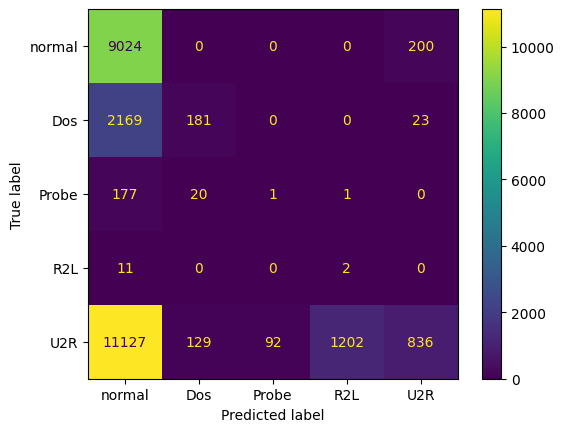

In [22]:
gnb_cm = confusion_matrix(y_test, gnb_pred)
ConfusionMatrixDisplay(gnb_cm,display_labels=target_names).plot()

In [23]:
print(classification_report(y_test, gnb_pred, target_names=target_names))

              precision    recall  f1-score   support

      normal       0.40      0.98      0.57      9224
         Dos       0.55      0.08      0.13      2373
       Probe       0.01      0.01      0.01       199
         R2L       0.00      0.15      0.00        13
         U2R       0.79      0.06      0.12     13386

    accuracy                           0.40     25195
   macro avg       0.35      0.26      0.17     25195
weighted avg       0.62      0.40      0.28     25195



In [24]:
dt = DecisionTreeClassifier()
dt = dt.fit(X_train, y_train)

In [25]:
dt_pred = dt.predict(x_test)
dt_pred

array([0, 1, 4, ..., 0, 0, 0])

In [26]:
dt_acc = accuracy_score(y_test, dt_pred)
dt_acc

0.998333002579877

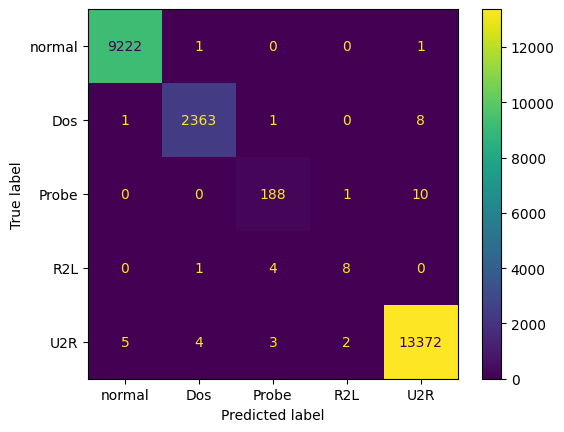

In [27]:
dt_cm = confusion_matrix(y_test, dt_pred)
ConfusionMatrixDisplay(dt_cm, display_labels=target_names).plot()

In [28]:
print(classification_report(y_test, dt_pred, target_names=target_names))

              precision    recall  f1-score   support

      normal       1.00      1.00      1.00      9224
         Dos       1.00      1.00      1.00      2373
       Probe       0.96      0.94      0.95       199
         R2L       0.73      0.62      0.67        13
         U2R       1.00      1.00      1.00     13386

    accuracy                           1.00     25195
   macro avg       0.94      0.91      0.92     25195
weighted avg       1.00      1.00      1.00     25195



In [29]:
rf = RandomForestClassifier()
rf = rf.fit(X_train, y_train)

In [30]:
rf_pred = rf.predict(x_test)
rf_pred

array([0, 1, 4, ..., 0, 0, 0])

In [31]:
rf_acc = accuracy_score(y_test, rf_pred)
rf_acc

0.9994443341932924

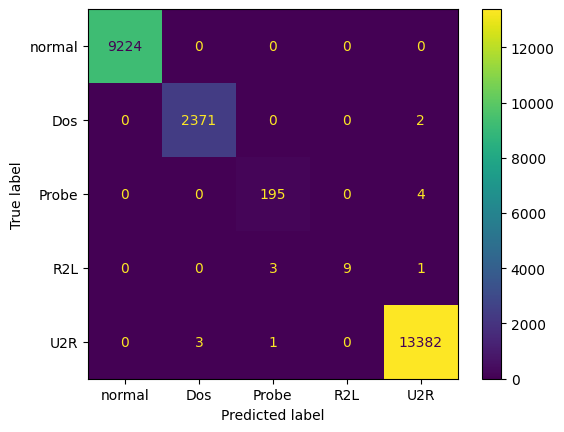

In [32]:
rf_cm = confusion_matrix(y_test, rf_pred)
ConfusionMatrixDisplay(rf_cm, display_labels=target_names).plot()

In [33]:
print(classification_report(y_test, rf_pred, target_names=target_names))

              precision    recall  f1-score   support

      normal       1.00      1.00      1.00      9224
         Dos       1.00      1.00      1.00      2373
       Probe       0.98      0.98      0.98       199
         R2L       1.00      0.69      0.82        13
         U2R       1.00      1.00      1.00     13386

    accuracy                           1.00     25195
   macro avg       1.00      0.93      0.96     25195
weighted avg       1.00      1.00      1.00     25195



In [34]:
cb = CatBoostClassifier()
cb = cb.fit(X_train, y_train)

Learning rate set to 0.100114
0:	learn: 1.2544516	total: 222ms	remaining: 3m 42s
1:	learn: 1.0354755	total: 269ms	remaining: 2m 14s
2:	learn: 0.8799860	total: 316ms	remaining: 1m 45s
3:	learn: 0.7587491	total: 361ms	remaining: 1m 29s
4:	learn: 0.6614147	total: 411ms	remaining: 1m 21s
5:	learn: 0.5829969	total: 466ms	remaining: 1m 17s
6:	learn: 0.5172147	total: 515ms	remaining: 1m 13s
7:	learn: 0.4604901	total: 562ms	remaining: 1m 9s
8:	learn: 0.4112563	total: 614ms	remaining: 1m 7s
9:	learn: 0.3689419	total: 662ms	remaining: 1m 5s
10:	learn: 0.3332607	total: 715ms	remaining: 1m 4s
11:	learn: 0.3005307	total: 764ms	remaining: 1m 2s
12:	learn: 0.2731106	total: 807ms	remaining: 1m 1s
13:	learn: 0.2488503	total: 854ms	remaining: 1m
14:	learn: 0.2267947	total: 901ms	remaining: 59.1s
15:	learn: 0.2074740	total: 957ms	remaining: 58.9s
16:	learn: 0.1896271	total: 1.01s	remaining: 58.3s
17:	learn: 0.1724289	total: 1.06s	remaining: 57.7s
18:	learn: 0.1580366	total: 1.1s	remaining: 56.9s
19:	lear

161:	learn: 0.0052762	total: 7.51s	remaining: 38.8s
162:	learn: 0.0052291	total: 7.57s	remaining: 38.9s
163:	learn: 0.0052078	total: 7.63s	remaining: 38.9s
164:	learn: 0.0051895	total: 7.67s	remaining: 38.8s
165:	learn: 0.0051313	total: 7.71s	remaining: 38.7s
166:	learn: 0.0050956	total: 7.75s	remaining: 38.7s
167:	learn: 0.0050494	total: 7.79s	remaining: 38.6s
168:	learn: 0.0049956	total: 7.83s	remaining: 38.5s
169:	learn: 0.0049409	total: 7.86s	remaining: 38.4s
170:	learn: 0.0048816	total: 7.91s	remaining: 38.3s
171:	learn: 0.0048532	total: 7.95s	remaining: 38.3s
172:	learn: 0.0048368	total: 7.99s	remaining: 38.2s
173:	learn: 0.0048195	total: 8.03s	remaining: 38.1s
174:	learn: 0.0047949	total: 8.07s	remaining: 38.1s
175:	learn: 0.0047370	total: 8.12s	remaining: 38s
176:	learn: 0.0047337	total: 8.15s	remaining: 37.9s
177:	learn: 0.0046905	total: 8.19s	remaining: 37.8s
178:	learn: 0.0046616	total: 8.23s	remaining: 37.8s
179:	learn: 0.0046250	total: 8.27s	remaining: 37.7s
180:	learn: 0.

324:	learn: 0.0022407	total: 14.2s	remaining: 29.5s
325:	learn: 0.0022374	total: 14.2s	remaining: 29.5s
326:	learn: 0.0022335	total: 14.3s	remaining: 29.4s
327:	learn: 0.0022292	total: 14.3s	remaining: 29.3s
328:	learn: 0.0022090	total: 14.4s	remaining: 29.3s
329:	learn: 0.0021982	total: 14.4s	remaining: 29.2s
330:	learn: 0.0021962	total: 14.4s	remaining: 29.2s
331:	learn: 0.0021826	total: 14.5s	remaining: 29.1s
332:	learn: 0.0021769	total: 14.5s	remaining: 29.1s
333:	learn: 0.0021679	total: 14.5s	remaining: 29s
334:	learn: 0.0021513	total: 14.6s	remaining: 29s
335:	learn: 0.0021498	total: 14.6s	remaining: 28.9s
336:	learn: 0.0021399	total: 14.7s	remaining: 28.9s
337:	learn: 0.0021282	total: 14.7s	remaining: 28.8s
338:	learn: 0.0021243	total: 14.7s	remaining: 28.7s
339:	learn: 0.0021179	total: 14.8s	remaining: 28.7s
340:	learn: 0.0021150	total: 14.8s	remaining: 28.6s
341:	learn: 0.0021106	total: 14.9s	remaining: 28.6s
342:	learn: 0.0021006	total: 14.9s	remaining: 28.5s
343:	learn: 0.00

486:	learn: 0.0013364	total: 20.8s	remaining: 21.9s
487:	learn: 0.0013340	total: 20.9s	remaining: 21.9s
488:	learn: 0.0013292	total: 20.9s	remaining: 21.9s
489:	learn: 0.0013242	total: 21s	remaining: 21.8s
490:	learn: 0.0013166	total: 21s	remaining: 21.8s
491:	learn: 0.0013135	total: 21s	remaining: 21.7s
492:	learn: 0.0013112	total: 21.1s	remaining: 21.7s
493:	learn: 0.0013091	total: 21.1s	remaining: 21.6s
494:	learn: 0.0012996	total: 21.2s	remaining: 21.6s
495:	learn: 0.0012945	total: 21.2s	remaining: 21.6s
496:	learn: 0.0012915	total: 21.3s	remaining: 21.5s
497:	learn: 0.0012874	total: 21.3s	remaining: 21.5s
498:	learn: 0.0012813	total: 21.4s	remaining: 21.4s
499:	learn: 0.0012788	total: 21.4s	remaining: 21.4s
500:	learn: 0.0012743	total: 21.4s	remaining: 21.4s
501:	learn: 0.0012695	total: 21.5s	remaining: 21.3s
502:	learn: 0.0012661	total: 21.5s	remaining: 21.3s
503:	learn: 0.0012607	total: 21.6s	remaining: 21.2s
504:	learn: 0.0012576	total: 21.6s	remaining: 21.2s
505:	learn: 0.0012

646:	learn: 0.0008633	total: 27.6s	remaining: 15s
647:	learn: 0.0008625	total: 27.6s	remaining: 15s
648:	learn: 0.0008588	total: 27.6s	remaining: 14.9s
649:	learn: 0.0008577	total: 27.7s	remaining: 14.9s
650:	learn: 0.0008548	total: 27.7s	remaining: 14.9s
651:	learn: 0.0008538	total: 27.8s	remaining: 14.8s
652:	learn: 0.0008523	total: 27.8s	remaining: 14.8s
653:	learn: 0.0008492	total: 27.9s	remaining: 14.7s
654:	learn: 0.0008482	total: 27.9s	remaining: 14.7s
655:	learn: 0.0008472	total: 27.9s	remaining: 14.7s
656:	learn: 0.0008466	total: 28s	remaining: 14.6s
657:	learn: 0.0008453	total: 28s	remaining: 14.6s
658:	learn: 0.0008434	total: 28.1s	remaining: 14.5s
659:	learn: 0.0008404	total: 28.1s	remaining: 14.5s
660:	learn: 0.0008401	total: 28.1s	remaining: 14.4s
661:	learn: 0.0008392	total: 28.2s	remaining: 14.4s
662:	learn: 0.0008381	total: 28.2s	remaining: 14.3s
663:	learn: 0.0008372	total: 28.3s	remaining: 14.3s
664:	learn: 0.0008362	total: 28.3s	remaining: 14.3s
665:	learn: 0.000833

807:	learn: 0.0006330	total: 34.3s	remaining: 8.16s
808:	learn: 0.0006309	total: 34.4s	remaining: 8.12s
809:	learn: 0.0006299	total: 34.4s	remaining: 8.07s
810:	learn: 0.0006274	total: 34.5s	remaining: 8.03s
811:	learn: 0.0006266	total: 34.5s	remaining: 7.99s
812:	learn: 0.0006261	total: 34.6s	remaining: 7.95s
813:	learn: 0.0006254	total: 34.6s	remaining: 7.91s
814:	learn: 0.0006247	total: 34.6s	remaining: 7.86s
815:	learn: 0.0006236	total: 34.7s	remaining: 7.82s
816:	learn: 0.0006233	total: 34.7s	remaining: 7.78s
817:	learn: 0.0006224	total: 34.8s	remaining: 7.73s
818:	learn: 0.0006213	total: 34.8s	remaining: 7.69s
819:	learn: 0.0006200	total: 34.8s	remaining: 7.65s
820:	learn: 0.0006190	total: 34.9s	remaining: 7.61s
821:	learn: 0.0006173	total: 34.9s	remaining: 7.56s
822:	learn: 0.0006162	total: 35s	remaining: 7.52s
823:	learn: 0.0006143	total: 35s	remaining: 7.47s
824:	learn: 0.0006142	total: 35s	remaining: 7.43s
825:	learn: 0.0006125	total: 35.1s	remaining: 7.39s
826:	learn: 0.0006

968:	learn: 0.0004908	total: 41s	remaining: 1.31s
969:	learn: 0.0004907	total: 41.1s	remaining: 1.27s
970:	learn: 0.0004901	total: 41.1s	remaining: 1.23s
971:	learn: 0.0004897	total: 41.2s	remaining: 1.19s
972:	learn: 0.0004892	total: 41.2s	remaining: 1.14s
973:	learn: 0.0004885	total: 41.2s	remaining: 1.1s
974:	learn: 0.0004880	total: 41.3s	remaining: 1.06s
975:	learn: 0.0004872	total: 41.3s	remaining: 1.02s
976:	learn: 0.0004869	total: 41.4s	remaining: 974ms
977:	learn: 0.0004861	total: 41.4s	remaining: 932ms
978:	learn: 0.0004843	total: 41.5s	remaining: 890ms
979:	learn: 0.0004839	total: 41.5s	remaining: 847ms
980:	learn: 0.0004835	total: 41.6s	remaining: 805ms
981:	learn: 0.0004823	total: 41.6s	remaining: 763ms
982:	learn: 0.0004818	total: 41.7s	remaining: 721ms
983:	learn: 0.0004812	total: 41.7s	remaining: 678ms
984:	learn: 0.0004804	total: 41.7s	remaining: 636ms
985:	learn: 0.0004792	total: 41.8s	remaining: 593ms
986:	learn: 0.0004778	total: 41.8s	remaining: 551ms
987:	learn: 0.0

In [35]:
cb_pred = cb.predict(x_test)
cb_pred

array([[0],
       [1],
       [4],
       ...,
       [0],
       [0],
       [0]], dtype=int64)

In [36]:
cb_acc = accuracy_score(y_test, cb_pred)
cb_acc

0.9994840246080572

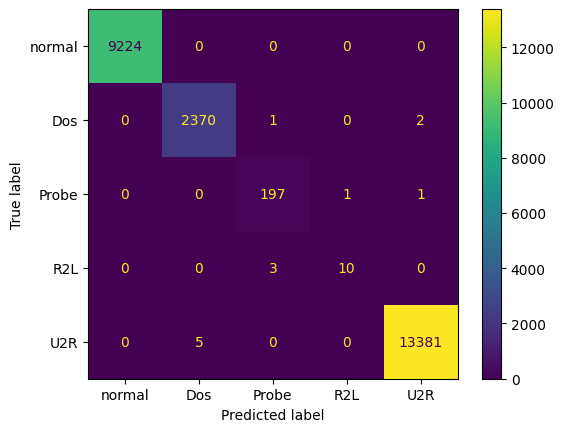

In [37]:
cb_cm = confusion_matrix(y_test, cb_pred)
ConfusionMatrixDisplay(cb_cm,display_labels=target_names).plot()

In [38]:
print(classification_report(y_test, cb_pred, target_names=target_names))

              precision    recall  f1-score   support

      normal       1.00      1.00      1.00      9224
         Dos       1.00      1.00      1.00      2373
       Probe       0.98      0.99      0.98       199
         R2L       0.91      0.77      0.83        13
         U2R       1.00      1.00      1.00     13386

    accuracy                           1.00     25195
   macro avg       0.98      0.95      0.96     25195
weighted avg       1.00      1.00      1.00     25195



In [39]:
xg = XGBClassifier(n_estimators=100, learning_rate=1, objective='multi:softmax', random_state=42)
xg = xg.fit(X_train, y_train)

In [40]:
xg_pred = xg.predict(x_test)
xg_pred

array([0, 1, 4, ..., 0, 0, 0])

In [41]:
xg_acc = accuracy_score(y_test, xg_pred)
xg_acc

0.999523715022822

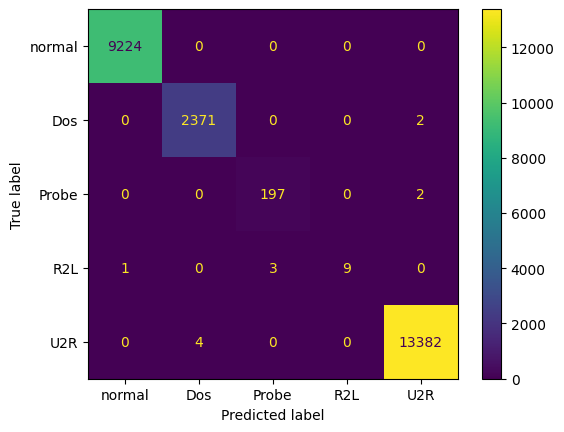

In [42]:
xg_cm = confusion_matrix(y_test, xg_pred)
ConfusionMatrixDisplay(xg_cm,display_labels=target_names).plot()

In [43]:
print(classification_report(y_test, cb_pred, target_names=target_names))

              precision    recall  f1-score   support

      normal       1.00      1.00      1.00      9224
         Dos       1.00      1.00      1.00      2373
       Probe       0.98      0.99      0.98       199
         R2L       0.91      0.77      0.83        13
         U2R       1.00      1.00      1.00     13386

    accuracy                           1.00     25195
   macro avg       0.98      0.95      0.96     25195
weighted avg       1.00      1.00      1.00     25195



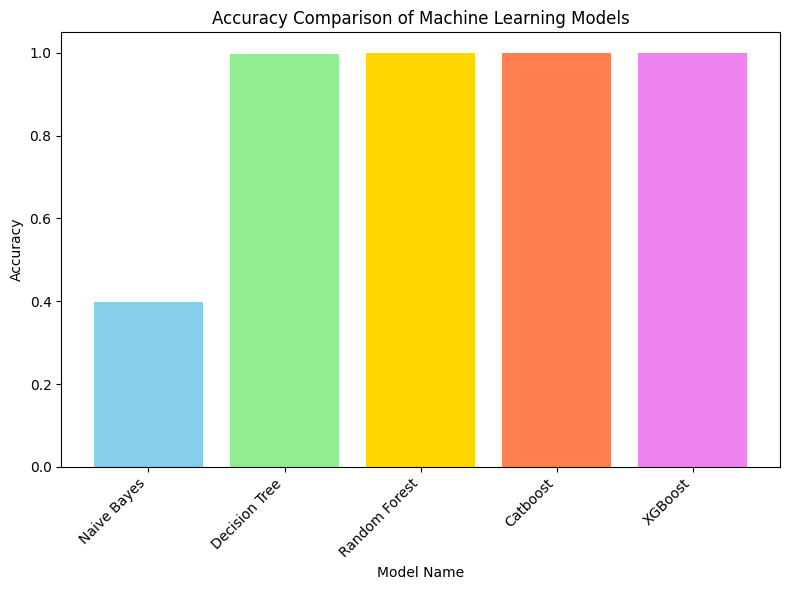

In [44]:
models = ['Naive Bayes', 'Decision Tree', 'Random Forest', 'Catboost', 'XGBoost']
accuracies = [gnb_acc, dt_acc, rf_acc, cb_acc, xg_acc]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'gold', 'coral', 'violet'])
plt.xlabel('Model Name')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Machine Learning Models')
plt.xticks(rotation=45, ha='right')


# Display the bar chart
plt.tight_layout()
plt.show()

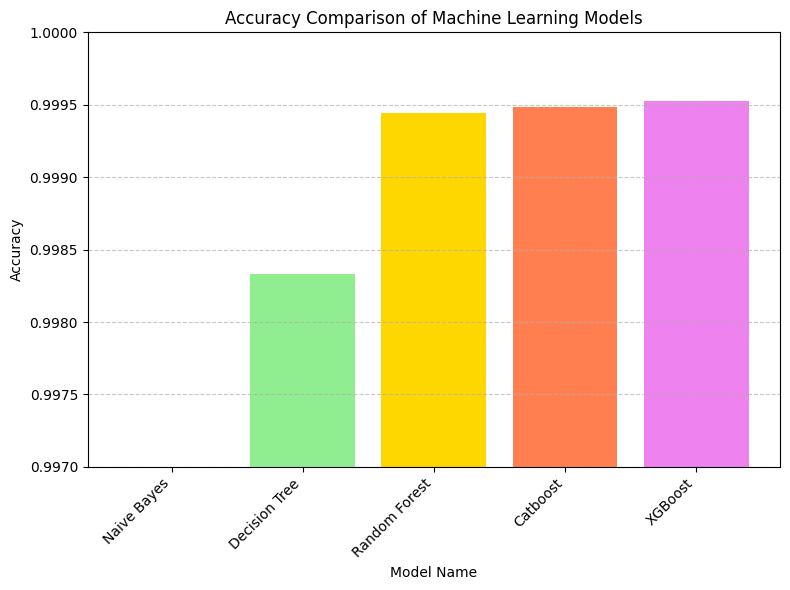

In [45]:
models = ['Naive Bayes', 'Decision Tree', 'Random Forest', 'Catboost', 'XGBoost']
accuracies = [gnb_acc, dt_acc, rf_acc, cb_acc, xg_acc]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'gold', 'coral', 'violet'])
plt.xlabel('Model Name')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Machine Learning Models')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set y-axis limits to focus on the narrow range
plt.ylim(0.997, 1.00)

# Display the bar chart
plt.tight_layout()
plt.show()

In [46]:
def false_alarm_rate(cm):
    true_normal = cm[0,0]
    false_attack = cm[0,1] + cm[0,2] + cm[0,3] + cm[0,4]
    
    return false_attack/(true_normal + false_attack)

In [47]:
gnb_far = false_alarm_rate(gnb_cm)
dt_far = false_alarm_rate(dt_cm)
rf_far = false_alarm_rate(rf_cm)
cb_far = false_alarm_rate(cb_cm)
xg_far = false_alarm_rate(xg_cm)

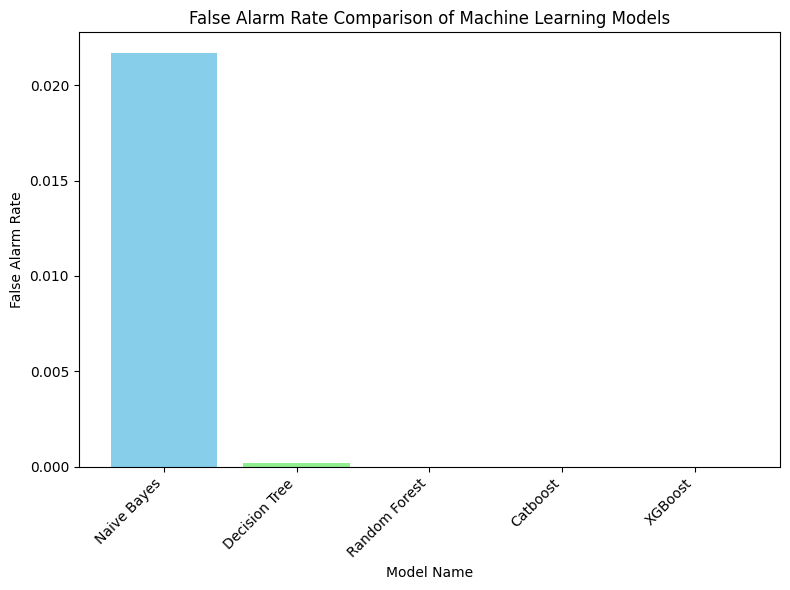

In [48]:
models = ['Naive Bayes', 'Decision Tree', 'Random Forest', 'Catboost', 'XGBoost']
accuracies = [gnb_far, dt_far, rf_far, cb_far, xg_far]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'gold', 'coral', 'violet'])
plt.xlabel('Model Name')
plt.ylabel('False Alarm Rate')
plt.title('False Alarm Rate Comparison of Machine Learning Models')
plt.xticks(rotation=45, ha='right')


# Display the bar chart
plt.tight_layout()
plt.show()

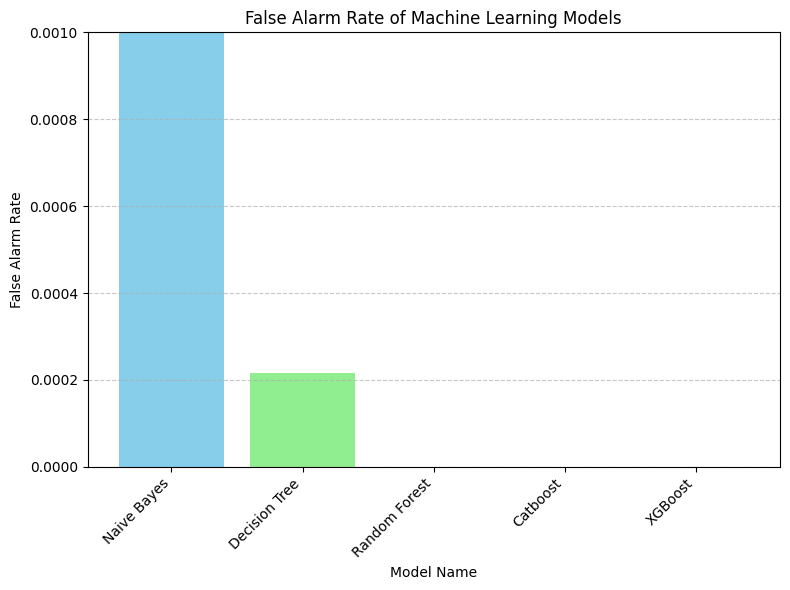

In [49]:
models = ['Naive Bayes', 'Decision Tree', 'Random Forest', 'Catboost', 'XGBoost']
accuracies = [gnb_far, dt_far, rf_far, cb_far, xg_far]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'gold', 'coral', 'violet'])
plt.xlabel('Model Name')
plt.ylabel('False Alarm Rate')
plt.title('False Alarm Rate of Machine Learning Models')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set y-axis limits to focus on the narrow range
plt.ylim(0, 0.001)

# Display the bar chart
plt.tight_layout()
plt.show()

In [50]:
import pickle
from joblib import dump, load

In [51]:
filename = 'best_model.sav'
pickle.dump(xg, open(filename, 'wb'))

In [52]:
import socket
from scapy.all import sniff
from unittest.mock import patch

import random

In [53]:
df_test = pd.read_csv('DATA/KDDTest-21.txt')

columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot'
,'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations'
,'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate'
,'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count'
,'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate'
,'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','attack','level'])

df_test.columns = columns
df_test

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,udp,private,SF,44,0,0,0,0,0,...,1.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,snmpguess,12
1,0,tcp,telnet,S3,0,44,0,0,0,0,...,0.31,0.61,0.00,0.00,0.21,0.68,0.60,0.00,processtable,18
2,0,udp,private,SF,53,55,0,0,0,0,...,1.00,0.00,0.87,0.00,0.00,0.00,0.00,0.00,normal,17
3,0,tcp,private,SH,0,0,0,0,0,0,...,0.06,1.00,1.00,0.00,1.00,1.00,0.00,0.00,nmap,17
4,0,tcp,http,SF,54540,8314,0,0,0,2,...,0.90,0.01,0.00,0.00,0.00,0.00,0.01,0.00,back,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11844,0,udp,domain_u,SF,43,43,0,0,0,0,...,1.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,normal,18
11845,0,tcp,http,SF,336,285,0,0,0,0,...,0.92,0.02,0.00,0.00,0.00,0.00,0.05,0.00,normal,18
11846,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.37,0.03,0.01,0.02,0.05,0.08,0.85,0.58,mscan,13
11847,0,tcp,sunrpc,REJ,0,0,0,0,0,0,...,0.19,0.03,0.01,0.04,0.00,0.00,0.88,1.00,mscan,15


In [54]:
df_test = df_test.drop(['attack', 'level'], axis=1)

In [55]:
loaded_model = pickle.load(open(filename, 'rb'))

In [56]:
def intrusion_check(packet):
    packet[1] = le_protocol_type.transform([packet[1]])[0]
    packet[2] = le_service.transform([packet[2]])[0]
    packet[3] = le_flag.transform([packet[3]])[0]
    pred = loaded_model.predict(np.reshape(packet, (1, 41)))
    predicted = le_attack.inverse_transform(pred)
    
    return predicted[0]

In [57]:
def capture_packet(count=float('inf')):
    filtered_packets = []

    def handle_sniffed_packet(packet):
        num = random.randint(0, 11849)
        check = intrusion_check(list(df_test.iloc[num]))
        if check == 'normal':
            filtered_packets.append(packet)
            print(f'Packet Safe, From [{packet.src}] To [{packet.dst}]')
        else:
            print(f'Caution! Found {check}, From [{packet.src}] To [{packet.dst}]')

    # Start capturing packets using sniff
    sniff(prn=handle_sniffed_packet, count=count)

    return filtered_packets

In [58]:
# Capture 20 packets and receive the safe packets
packets = capture_packet(20)

RuntimeError: Sniffing and sending packets is not available at layer 2: winpcap is not installed. You may use conf.L3socket orconf.L3socket6 to access layer 3

In [ ]:
packets[0]

In [ ]:
# Capture packets until stop button is clicked and receive the safe packets
packets = capture_packet()